In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from sklearn.metrics import f1_score
import tensorflow as tf
import datetime

%load_ext autoreload
%autoreload 2
    
import ml_utils.road_seg as rs
import ml_utils.model as model
import ml_utils.data_augmentation as d_aug

In [2]:
path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'

# 2. Model training


In [ ]:
import ml_utils.model as model

m = model.Model(model_type='cnn_bn')

In [ ]:
m.train_model(path_train_dir, n_epoch=80, display_epoch=5, nmax=10, n_aug=400, n_worst=50)

In [ ]:
m.plot_stats()

# 3. Results vizualisation


In [3]:
file_save = 'model/2017_12_18_07h39_cnn_bn_model.ckpt'

m = model.Model(model_type='cnn_bn')

conv1_1 size (?, ?, ?, 64)
conv1_2 size (?, ?, ?, 64)
conv1_3 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2_1 size (?, ?, ?, 64)
conv2_2 size (?, ?, ?, 64)
conv2_3 size (?, ?, ?, 64)
pool2 size (?, ?, ?, 64)
conv3_1 size (?, ?, ?, 64)
conv3_2 size (?, ?, ?, 64)
conv3_3 size (?, ?, ?, 64)
pool3 size (?, ?, ?, 64)
conv4_1 size (?, ?, ?, 64)
conv4_2 size (?, ?, ?, 64)
conv4_3 size (?, ?, ?, 64)
pool4 size (?, ?, ?, 64)
conv5_1 size (?, ?, ?, 64)
conv5_2 size (?, ?, ?, 64)
deconv1 size (?, ?, ?, 64)
deconv1_c size (?, ?, ?, 128)
conv6_1 size (?, ?, ?, 96)
conv6_2 size (?, ?, ?, 64)
deconv2 size (?, ?, ?, 64)
deconv2_c size (?, ?, ?, 128)
conv7_1 size (?, ?, ?, 96)
conv7_2 size (?, ?, ?, 64)
deconv3 size (?, ?, ?, 64)
deconv3_c size (?, ?, ?, 128)
conv8_1 size (?, ?, ?, 96)
conv8_2 size (?, ?, ?, 64)
deconv4 size (?, ?, ?, 64)
deconv4_c size (?, ?, ?, 128)
conv9_1 size (?, ?, ?, 96)
conv9_2 size (?, ?, ?, 64)
score size (?, ?, ?, 2)


In [4]:
train_imgs, train_gt, val_imgs, val_gt = m._get_base_sets(ratio=0.8)
train_imgs, _, _ = rs.normalize_data(train_imgs, mode='all', mean_ref = m.mean, std_ref = m.std) 
val_imgs, _, _ = rs.normalize_data(val_imgs, mode='all', mean_ref = m.mean, std_ref = m.std) 

In [5]:
y_pred_train = m.apply_model(train_imgs, file_save)
print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
y_pred_valid = m.apply_model(val_imgs, file_save)
print('F1-score validation: {}'.format(m.predict_f1(val_gt, y_pred_valid)))

INFO:tensorflow:Restoring parameters from model/2017_12_18_07h39_cnn_bn_model.ckpt
F1-score train: 0.9572808465914902
INFO:tensorflow:Restoring parameters from model/2017_12_18_07h39_cnn_bn_model.ckpt
F1-score validation: 0.9137836729876884


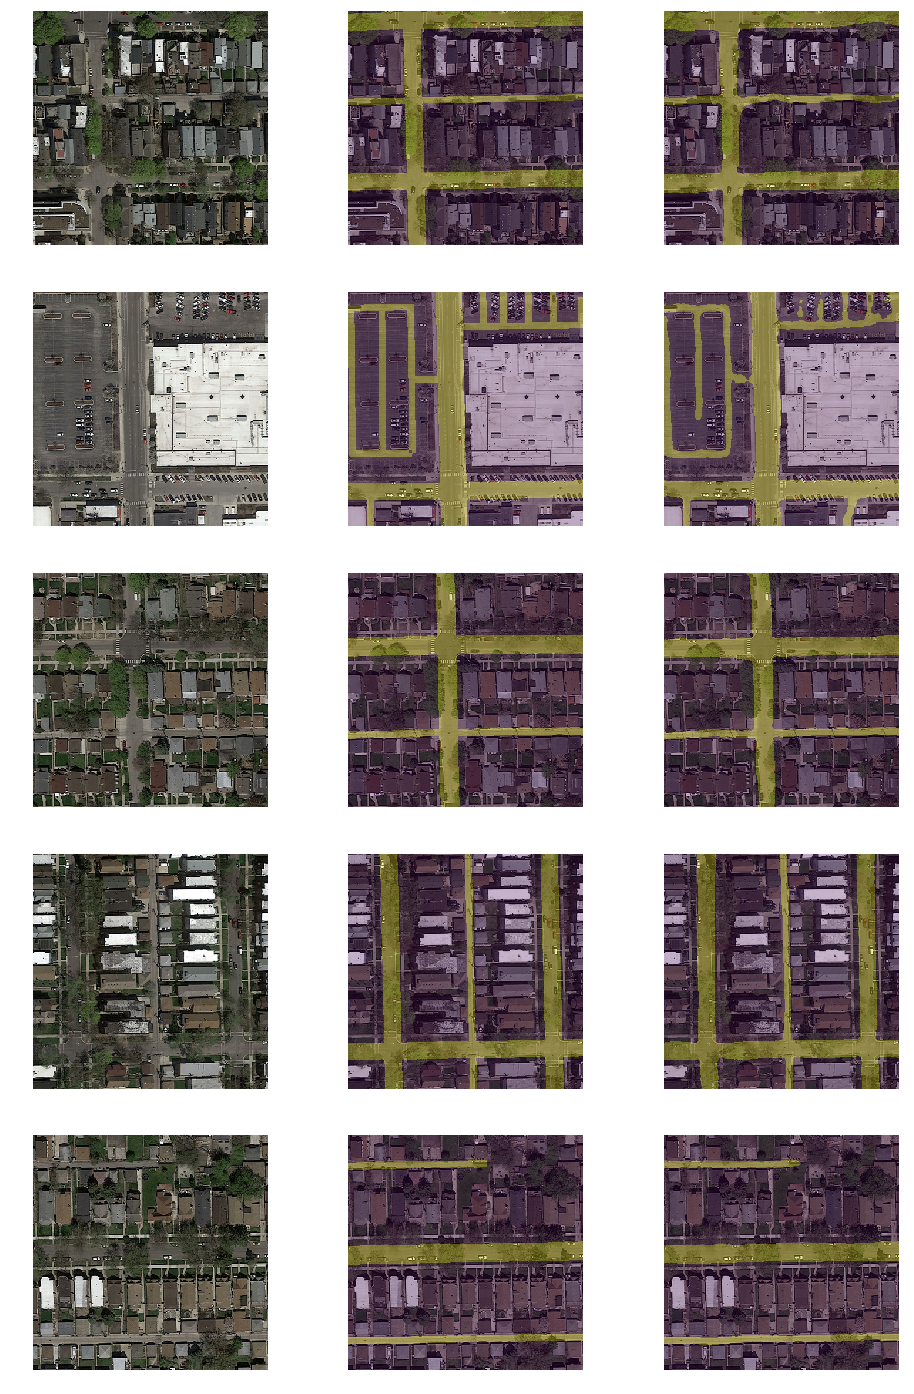

In [6]:
train_imgs, train_gt, val_imgs, val_gt = m._get_base_sets(ratio=0.8)
rs.display_predictions(y_pred_train, train_imgs, train_gt, n_display=5)

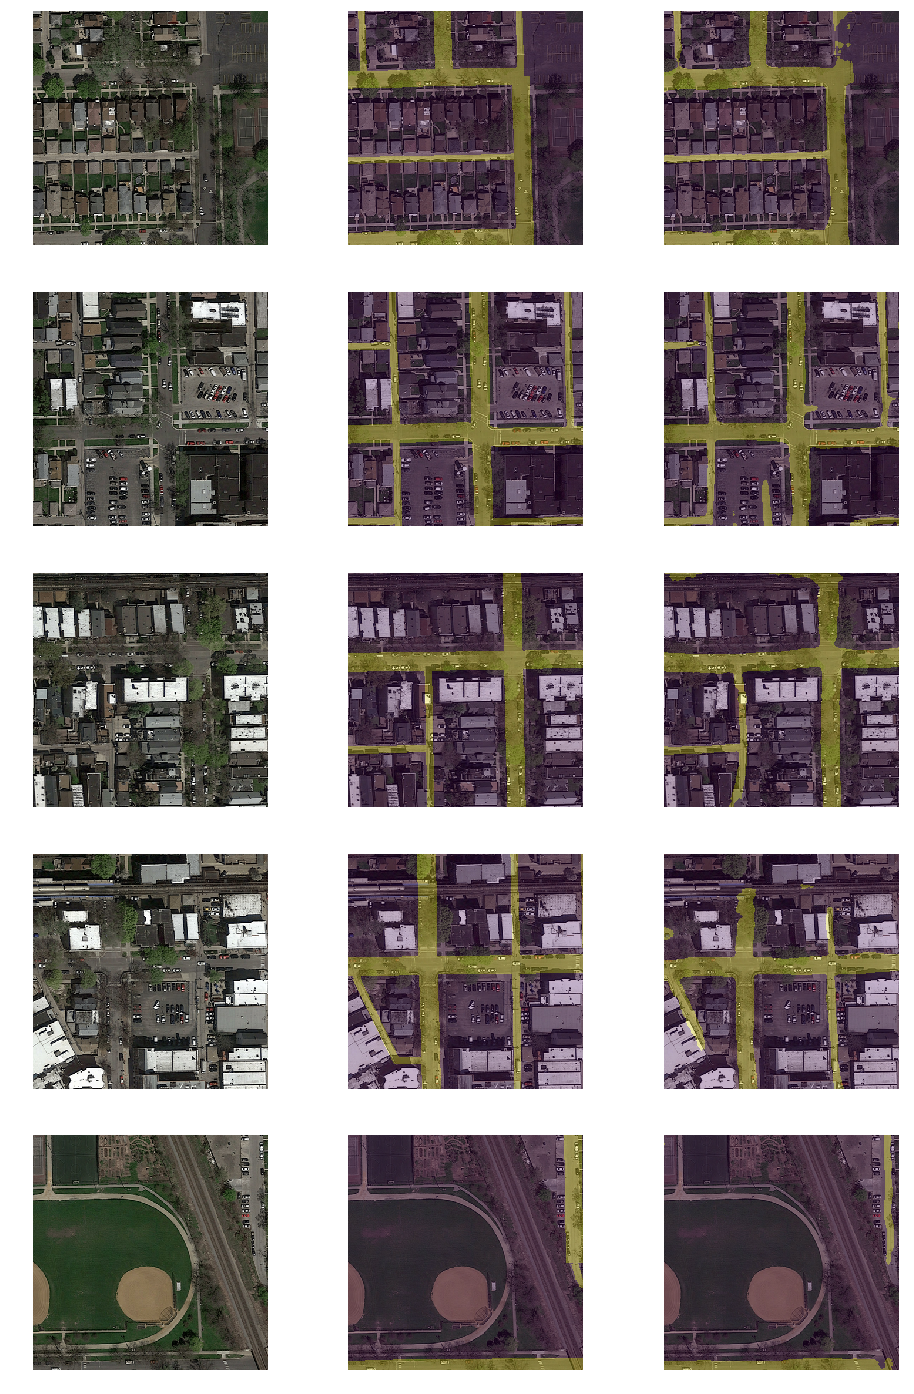

In [7]:
rs.display_predictions(y_pred_valid, val_imgs, val_gt, n_display=5)

In [86]:
from skimage.morphology import skeletonize, thin, skeletonize_3d
from skimage import data
import matplotlib.pyplot as plt
from skimage.morphology import disk, closing, opening, remove_small_objects, dilation
from skimage.measure import label, regionprops

def process_cgt(img):
    
    r = closing(img, disk(5))
    corr = skeletonize_3d(r.astype(np.uint8))
    z = dilation(corr, disk(5))
    res = (r + z) >= 1
    res = remove_small_objects(res.astype(bool), min_size = 200)
    
    label_image = label(res)
    
    for i, region in enumerate(regionprops(label_image)):
        minr, minc, maxr, maxc = region.bbox
        if minr == 0 or minc == 0 or maxr == img.shape[0] or maxc == img.shape[0]:
            continue

        label_image[label_image == i+1] = 0
        
    return label_image >= 1

def process_all(ypreds, size_image=400):

    pred_proc = np.reshape(ypreds, (-1, size_image, size_image)).copy()
    
    for i in range(pred_proc.shape[0]):
        pred_proc[i] = process_cgt(pred_proc[i])
    
    return pred_proc.flatten()


# fig, axes = plt.subplots(1, 3, figsize=(16, 8))
# axes[0].imshow(train_imgs[id_image]); axes[0].imshow(img_gt, alpha=0.5)
# axes[1].imshow(train_imgs[id_image]); axes[1].imshow(img_pred, alpha=0.5)
# axes[2].imshow(train_imgs[id_image]); axes[2].imshow( (r + z) >= 1, alpha=0.5)


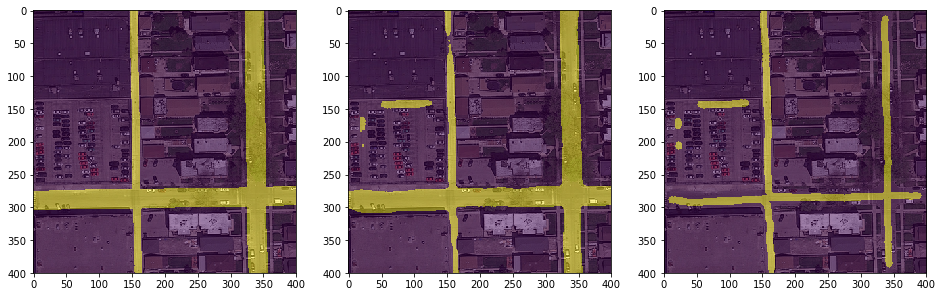

In [83]:
id_image = 6
img_gt = val_gt[id_image]
img_pred = np.reshape(y_pred_valid, (-1, 400, 400))[id_image]

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axes[0].imshow(val_imgs[id_image]); axes[0].imshow(img_gt, alpha=0.5)
axes[1].imshow(val_imgs[id_image]); axes[1].imshow(img_pred, alpha=0.5)
axes[2].imshow(val_imgs[id_image]); axes[2].imshow( process_cgt(img_pred), alpha=0.5)

In [72]:
pred_proc = process_all(y_pred_train)

print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
print('F1-score train: {}'.format(m.predict_f1(train_gt, pred_proc)))

/home/abbet/anaconda3/envs/pcml/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


F1-score train: 0.9572808465914902
F1-score train: 0.9542991415040414


In [73]:
pred_proc = process_all(y_pred_valid)

print('F1-score train: {}'.format(m.predict_f1(val_gt, y_pred_valid)))
print('F1-score train: {}'.format(m.predict_f1(val_gt, pred_proc)))

/home/abbet/anaconda3/envs/pcml/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


F1-score train: 0.9137836729876884
F1-score train: 0.9134474247882043


# 4. Post Process

In [14]:
test_img = rs.load_test_set(path_test)
test_img_norm, _, _ = rs.normalize_data(test_img, mode='all', mean_ref=m.mean, std_ref=m.std)

In [15]:
# m = model.Model(model_type='cnn_bn', display_log=False)
y_pred_test = m.apply_model(test_img_norm, file_save, nmax=2)

INFO:tensorflow:Restoring parameters from model/2017_12_18_07h39_cnn_bn_model.ckpt


In [87]:
y_pred_test_proc = process_all(y_pred_test, size_image=608)

/home/abbet/anaconda3/envs/pcml/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


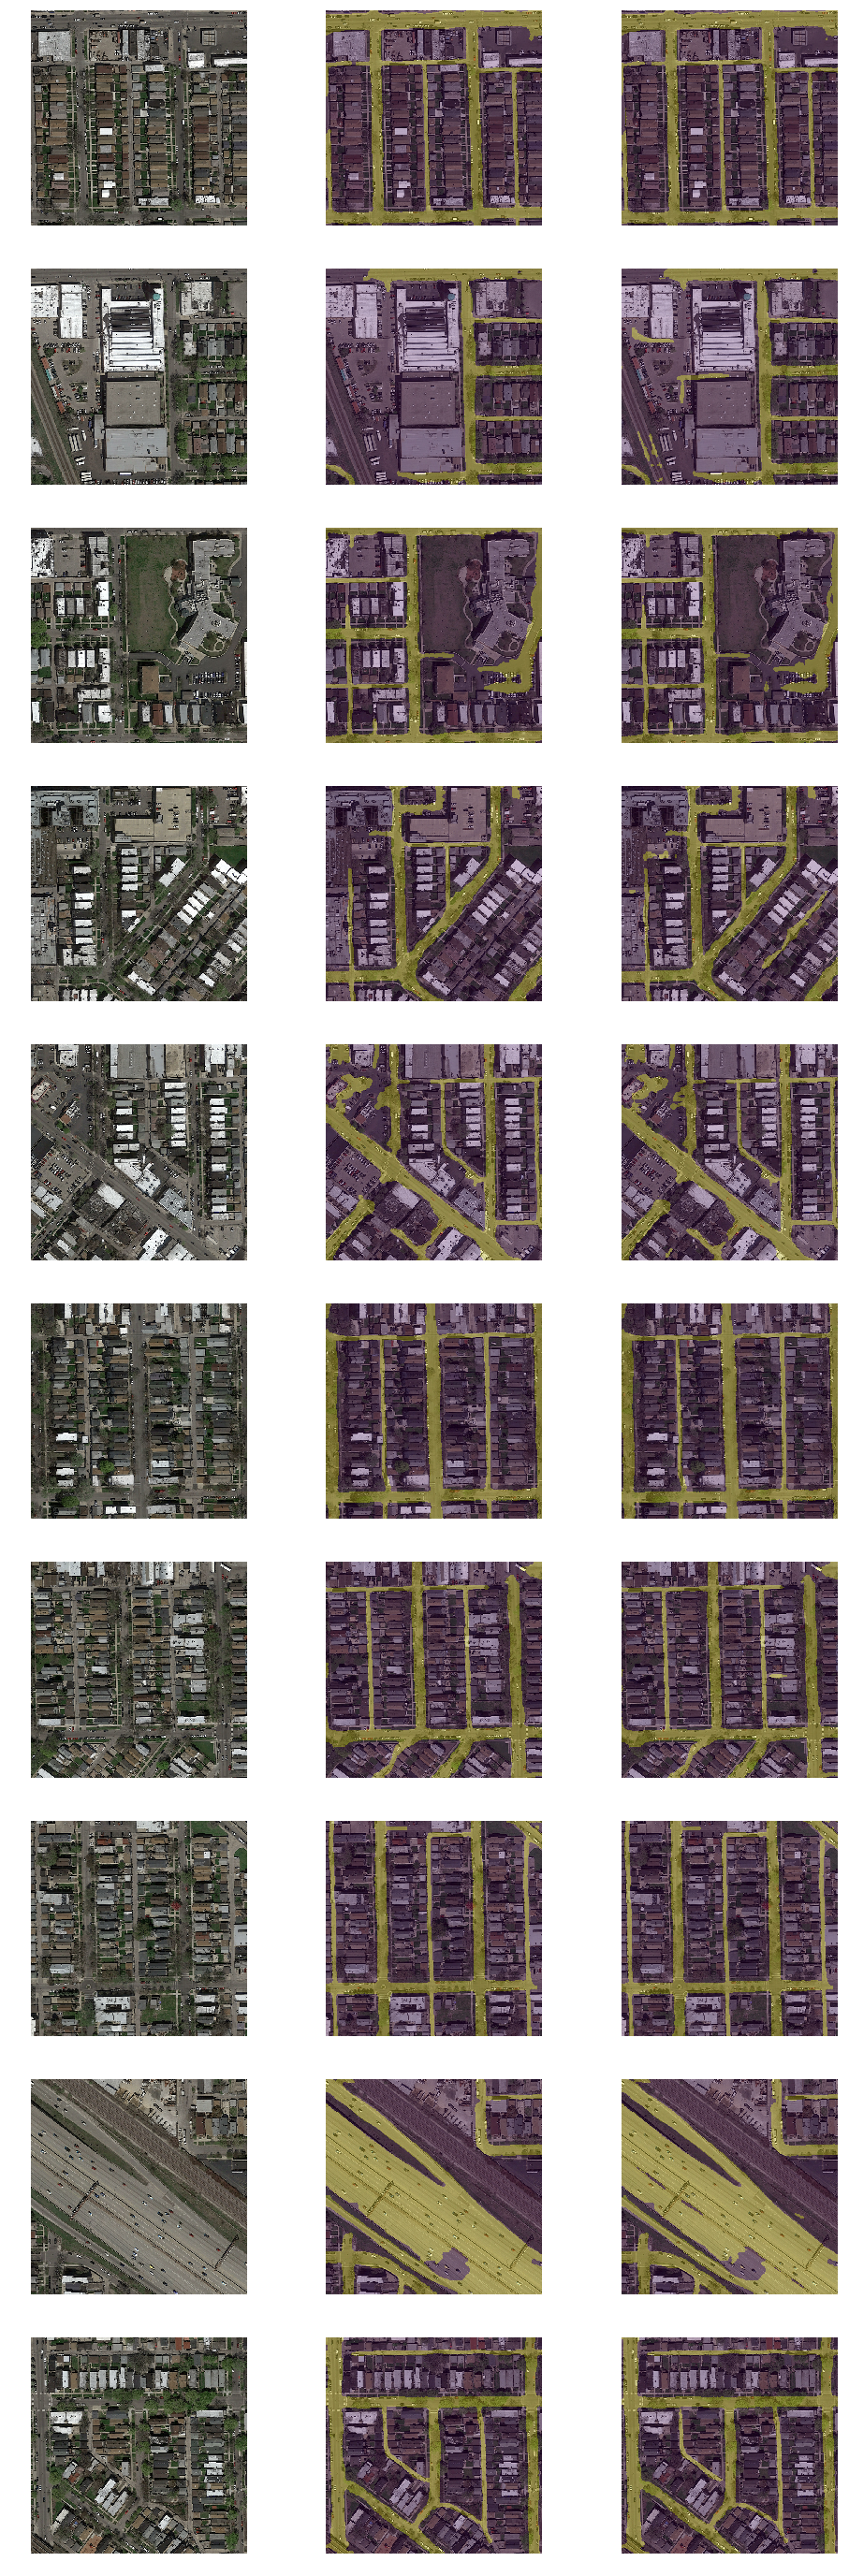

In [88]:
im_proc = np.reshape(y_pred_test_proc, (-1, 608, 608))
rs.display_predictions(y_pred_test, test_img, im_proc, n_display=10)

# 4. Submission

In [89]:
rs.create_submission(im_proc, 'test_150epoch_post4_dataaug_new.csv')